# eScience Incubator Project: Data Analytics for Demixing and Decoding Patterns of Population Neural Activity Underlying Addiction Behavior 

### Charles Zhou, Research Scientist at the Center in Neurobiology of Addiction, Pain, and Emotion

The aim of this project is to apply novel statistical and machine learning analysis techniques to large-scale 2-photon calcium imaging data with respect to addiction-related behaviors and assays.



![alt text](fig1.jpg "Title")

In [1]:
# load dependencies
import h5py
import tensortools as tt # toolbox for TCA
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle # for loading behav data
import utils
import importlib as imp

import xarray # for organizing and storing the data 
import pandas as pd
from sklearn_xarray import wrap
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

c:\users\stuberadmin\anaconda3\envs\escience_incubator\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
# indicate a file to analyze
filename = 'VJ_OFCVTA_7_260_D6'
root_dir = 'C:\\2pData\\Vijay data\\VJ_OFCVTA_7_D8_trained\\'
sima_h5_path = root_dir + filename + '_sima_mc.h5'

In [3]:
# trial windowing 

fs = 5
trial_window = np.array([-1, 3]) # in seconds relative to ttl-onset/trial-onset

### Understanding and preprocessing the data

The data are in h5 (HDF5) format, which has the advantage of being able to load portions of the data into memory at a time. Below, we load the data, reorganize the dimensions, and convert it into x-array format. X-array is a python-unique data structure that allows for storage of meta-data.

In [4]:
data_snip = utils.load_h5(sima_h5_path)
data_snip.shape

(499, 490, 15169)

In [5]:
# calculate some meta data

data_dims = data_snip.shape
tvec = np.linspace(0, data_dims[2]/fs, data_dims[2])

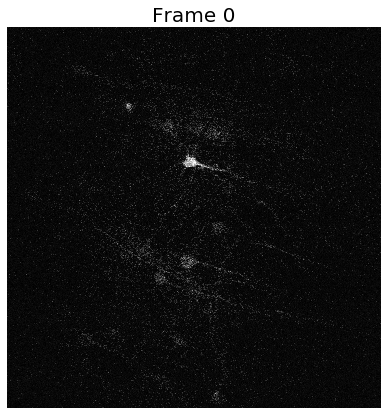

In [6]:
# let's plot the first frame from the video snippit
frame_num = 0
to_plot = data_snip[:,:,frame_num]

utils.plot_single_img(to_plot, frame_num) # function in custom code utils

### Let's take a look at the behavioral data.

During the brain recordings, animals perform a behavioral task (pavlovian conditioning) that allows for understanding how neural activity gives rise to memory encoding of rewards. The significance of examining this behavior is that addiction states are heavily based on associating a drug (unconditioned stimulus - US) to a particular cue (eg. heroin needle; conditioned stimulus - CS).

The figure below (Namboodiri et al., 2019 Nature Neuroscience) shows the recording setup and task:

![alt text](namboodiri_nn_fig1ab.png "Title")


We ultimately want to reshape the data for a certain session (typically y_pixels, x_pixels, time/samples) to be amenable to trial-by-trial classifcation in a neural network. The resulting reshaped dimensions will be: trial, y_pixels, x_pixels, time/samples. So for a session with two behavioral conditions 50 trials each, 512x512, and 3 second trials (at 5 hz, that's 15 samples), our resulting array/tensor will be: 100 x 512 x 512 x 15. 

Since we have orders of magnitude more values for x and y pixels than samples, we will ultimately be performing dimensionality reduction to make the dataset more tractable. We will perform dimensionality reduction across y_pixels, x_pixels, and time/samples.

In [7]:
#load behavioral data and trial info
glob_frame_files = glob.glob(root_dir + "framenumberforevents*") # look for a file in specified directory
frame_events = pickle.load( open( glob_frame_files[0], "rb" ), encoding="latin1" ) # latin1 b/c original pickle made in python 2

### Raw behavioral data organization

Across the whole recording session, the animal is presented with randomized stimuli paired with or without sucrose rewards (each presentation is considered a trial). 

The time (ie. sample) at which each trial occurs relative to the beginning of the session is recorded.



In [8]:
imp.reload(utils)

trial_window_samp = trial_window*fs # turn trial start/end times to samples

conditions = ['plus_rewarded','minus']

data_dict= utils.extract_trial_data(data_snip, trial_window_samp[0], trial_window_samp[1],
                                                       frame_events, conditions)

In [9]:
data_dict['minus']['data'].shape

(499, 490, 50, 21)

## Turn trial-extracted data to xarray

In [10]:
"""let's load data into xarray format, which has numerous 
advantages over using numpy arrays, one of which is the ability 
to assign names to dimensions rather than indexing by ints """

for condition in conditions:
    
    ypix_vec = range(0,data_dims[0])
    xpix_vec = range(0,data_dims[1])
    flattenpix_vec = range(0,data_dims[0]*data_dims[1])
    trials_vec = range(data_dict[condition]['num_trials'])
    trial_tvec = np.linspace(trial_window[0], trial_window[1], data_dict[condition]['num_samples'])

    # xarray with dims: x,y,trial,samples
    data_dict[condition]['xarr_data'] = xarray.DataArray(data_dict[condition]['data'], coords=[ypix_vec, xpix_vec, trials_vec, trial_tvec], dims=['y', 'x', 'trial', 'time'])

    # flatten x and y pixels into one dimension
    # reshape data and make xarray with dims: x-y,trial,samples
    flatten_pix_trial_data = np.reshape(data_dict[condition]['data'], (data_dims[0]*data_dims[1], len(trials_vec), len(trial_tvec)))
    data_dict[condition]['xarr_flatten_xy'] = xarray.DataArray( flatten_pix_trial_data, # this flattens only the x,y dimensions
                                       coords=[flattenpix_vec, trials_vec, trial_tvec], 
                                       dims=['yx', 'trial', 'time'])
    
    # average across trials
    data_dict[condition]['xarr_flatten_pix_trialAvg'] = data_dict[condition]['xarr_flatten_xy'].mean(dim = 'trial')
    

# Perform PCA Dimensionality Reduction Across Pixels

In [11]:
# perform PCA
variance_thresh = 0.9
pca_xr_wrapper = wrap(PCA(variance_thresh), reshapes='yx', random_state=5) # create PCA object and specify dimension to perform PCA on

Xt = pca_xr_wrapper.fit_transform(data_dict[condition]['xarr_flatten_pix_trialAvg'].transpose()) # fit/transform estimator; transpose to apply PCA on pixels
print(f"Xt: {Xt.shape}")

num_comps = pca_xr_wrapper.estimator_.n_components_

Xt: (21, 18)


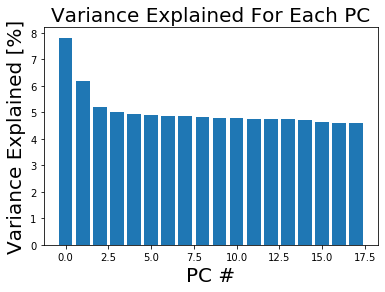

In [12]:
fig, ax = plt.subplots()
x_ticks = range(0,num_comps)
ax.bar(x_ticks, pca_xr_wrapper.estimator_.explained_variance_ratio_*100)
ax.set_title('Variance Explained For Each PC', fontsize = 20)
ax.set_ylabel('Variance Explained [%]', fontsize = 20)
ax.set_xlabel('PC #', fontsize = 20);

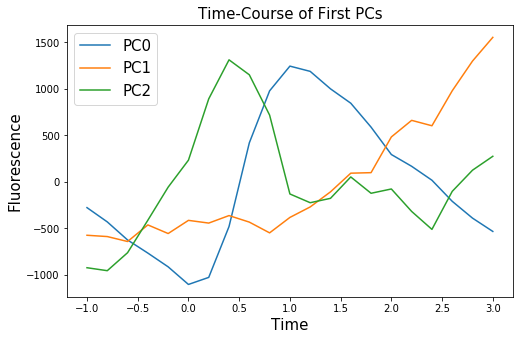

In [13]:
plt.figure(figsize = (8,5))
plt.plot(trial_tvec, Xt[:,:3])
plt.title('Time-Course of First PCs', fontsize = 15)
plt.ylabel('Fluorescence', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.legend(['PC0', 'PC1', 'PC2'], fontsize = 15);

In [37]:
pca_xr_wrapper.transform(data_dict[condition]['xarr_flatten_xy'][:,1,:].transpose()).shape

(21, 18)

In [17]:
# transform individsual trial data into trial-avg PC space

Xt_trials = np.empty_like(data_dict[condition]['xarr_flatten_xy'])

for idx, trial_dat in enumerate(data_dict[condition]['xarr_flatten_xy']):
    
     pca_xr_wrapper.transform(trial_dat)

ValueError: operands could not be broadcast together with shapes (50,21) (244510,) 

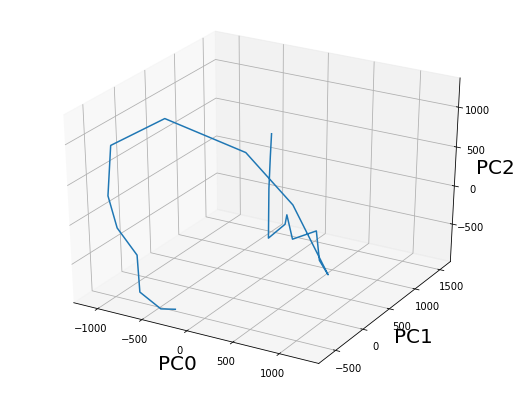

In [20]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (9,7))
ax = fig.gca(projection='3d')

ax.plot(Xt[:,0], Xt[:,1], Xt[:,2], label='parametric curve')
ax.set_xlabel('PC0', fontsize = 20)
ax.set_ylabel('PC1', fontsize = 20)
ax.set_zlabel('PC2', fontsize = 20);

### Let's check out the PCA estimator attributes

In [21]:
# function that takes in mean image and plots 
def subplot_heatmap(axs, title, image, clims=None, zoom_window=None):

    im = axs.imshow(image, cmap='seismic')
    axs.set_title(title, fontsize = 20)
    
    if zoom_window is not None:
        im.set_clim(vmin=clims[0], vmax=clims[1])
    
    if zoom_window is not None:
        
        axs.set_title(title, fontsize = 20)
        axs.axis(zoom_window)
        axs.invert_yaxis()
    axs.axis('off')
    
    return im # for colorbar
    

In [22]:
# function to make a figure with subplots of heatmaps
def plot_img_vectorized_component(n_columns, data):
    
    num_comps = data.shape[0]
    n_rows = int(np.ceil(num_comps/n_columns))

    fig, ax = plt.subplots(nrows=n_rows, ncols=n_columns, figsize = (15, n_rows*4))
    for iComp in range(num_comps):

        subplot_index = np.unravel_index(iComp, (n_rows, n_columns)) # turn int index to a tuple of array coordinates

        title = f"Comp {iComp}"
        pc_pixel_weights = data[iComp,:].reshape(data_dims[0],data_dims[1])

        im = subplot_heatmap(ax[subplot_index], title, pc_pixel_weights)
    

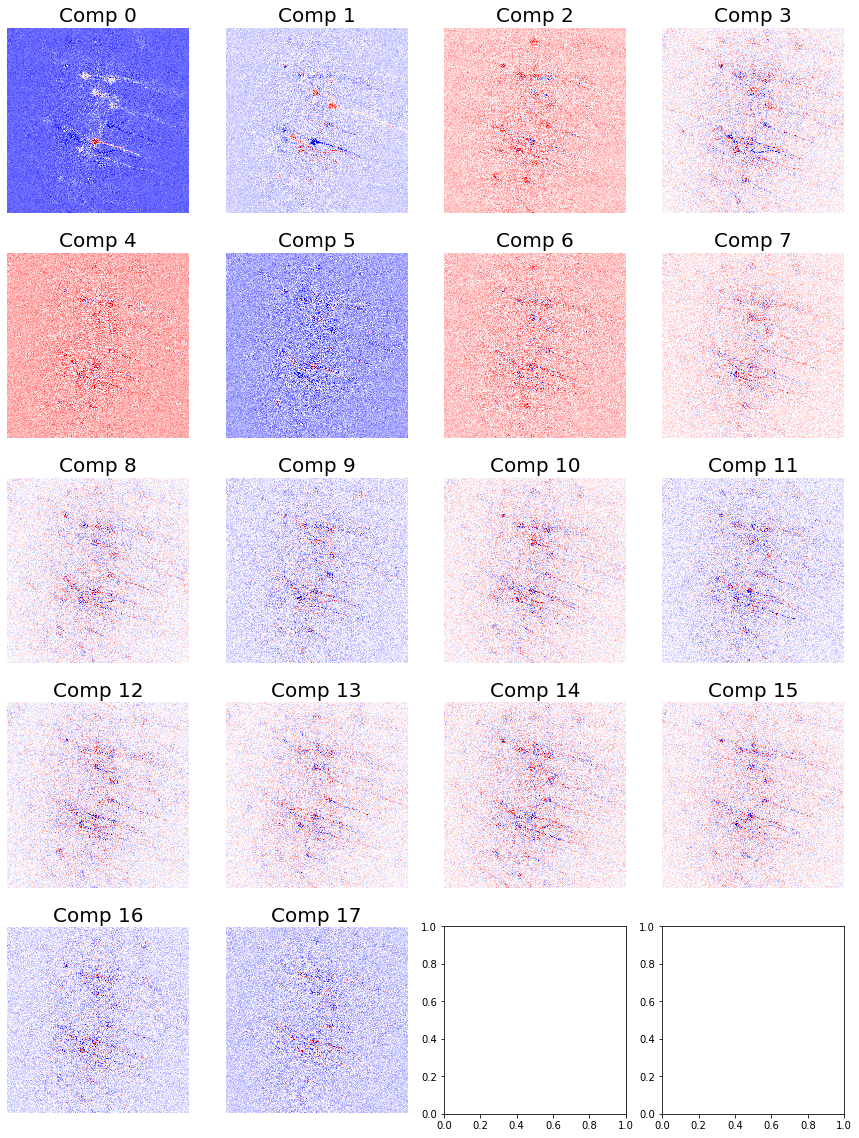

In [23]:
# For each PC, plot the eigenvectors: weights/contribution of each pixel

n_columns = 4
plot_img_vectorized_component(n_columns, pca_xr_wrapper.estimator_.components_)

# TCA

In [26]:
# Make synthetic dataset.
I = len(data_dict[condition]['xarr_flatten_xy'].yx)
J, K = data_dims[0], data_dims[1]
R = 3 # dimensions/rank
# R is number of components

X = data_dict[condition]['xarr_flatten_xy'].data
#dims are (yx_pix, trial, time)

CP_ALS: iteration 1, objective 0.6885532627578214, improvement inf.
CP_ALS: iteration 2, objective 0.6578924870630376, improvement 0.03066077569478376.
CP_ALS: iteration 3, objective 0.6550793752123507, improvement 0.002813111850686889.
CP_ALS: iteration 4, objective 0.6535256647952516, improvement 0.0015537104170990634.
CP_ALS: iteration 5, objective 0.6528076326788909, improvement 0.0007180321163607895.
CP_ALS: iteration 6, objective 0.6525496409115, improvement 0.0002579917673908305.
CP_ALS: iteration 7, objective 0.652421055765456, improvement 0.0001285851460440801.
CP_ALS: iteration 8, objective 0.6523577874572648, improvement 6.326830819114448e-05.
CP_ALS: iteration 9, objective 0.6523275493145376, improvement 3.0238142727179174e-05.
CP_ALS: iteration 10, objective 0.6523124085760499, improvement 1.5140738487740002e-05.
CP_ALS: iteration 11, objective 0.6523038244359158, improvement 8.584140134049179e-06.
Converged after 11 iterations, 78.74780220000001 seconds. Objective: 0.6523

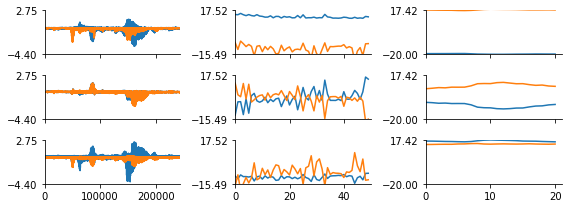

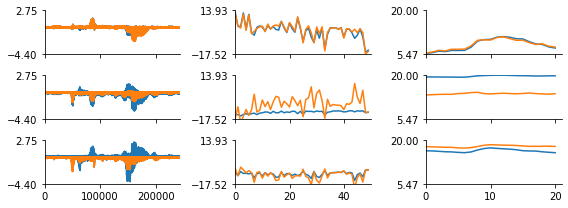

In [27]:

# Fit CP tensor decomposition (two times).
U = tt.cp_als(X, rank=R, verbose=True)
V = tt.cp_als(X, rank=R, verbose=True)

# Compare the low-dimensional factors from the two fits.
fig, _, _ = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)

# Align the two fits and print a similarity score.
sim = tt.kruskal_align(U.factors, V.factors, permute_U=True, permute_V=True)
print(sim)

# Plot the results again to see alignment.
fig, ax, po = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)

# Show plots.
plt.show()

IndexError: too many indices for array

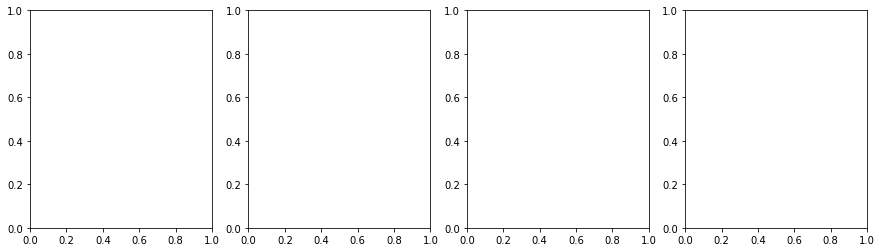

In [28]:
pixel_factor = 0
n_columns = 4

plot_img_vectorized_component(n_columns, np.transpose(V.factors[pixel_factor]))

In [ ]:


tseries = V.factors[2][:,component]
plt.figure()
plt.plot(trial_tvec, tseries)